In [ ]:
import os
import yaml
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim

from glob import glob
from tqdm import tqdm
from collections import OrderedDict
from source.utils import iou_score, AverageMeter
from albumentations.augmentations import transforms
from sklearn.model_selection import train_test_split
from albumentations.core.composition import Compose, OneOf

from train import train, validate
from source.network import UNetPP
from source.dataset import DataSet

In [2]:
with open("config.yaml") as f:
    config = yaml.load(f)

extn = config["extn"]
epochs = config["epochs"]
log_path = config["log_path"]
mask_path = config["mask_path"]
image_path = config["image_path"]
model_path = config["model_path"]

## Create log file

In [3]:
log = OrderedDict([
    ('epoch', []),
    ('loss', []),
    ('iou', []),
    ('val_loss', []),
    ('val_iou', []),
])

best_iou = 0
trigger = 0

## Split images into train and validation set

In [4]:
extn_ = f"*{extn}"
img_ids = glob(os.path.join(image_path, extn_))
img_ids = [os.path.splitext(os.path.basename(p))[0] for p in img_ids]
train_img_ids, val_img_ids = train_test_split(img_ids, test_size=0.2)

## Define data transformations

In [3]:
from albumentations.augmentations import geometric

In [19]:
train_transform = Compose([
    geometric.rotate.RandomRotate90(),
    geometric.transforms.Flip(),
    OneOf([
        transforms.HueSaturationValue(),
        transforms.RandomBrightnessContrast()
    ], p=1),
    geometric.resize.Resize(256, 256),
    transforms.Normalize(),
])

val_transform = Compose([
    geometric.resize.Resize(256, 256),
    transforms.Normalize(),
    ])

## Create train and validation dataset

In [20]:
train_dataset = DataSet(
    img_ids=train_img_ids,
    img_dir=image_path,
    mask_dir=mask_path,
    img_ext=extn,
    mask_ext=extn,
    transform=train_transform)

val_dataset = DataSet(
    img_ids=val_img_ids,
    img_dir=image_path,
    mask_dir=mask_path,
    img_ext=extn,
    mask_ext=extn,
    transform=val_transform)

## Create train and validation data loaders

In [ ]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    drop_last=True)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    drop_last=False)

## Create the model object

In [17]:
# Create model object
model = UNetPP(1, 3, True)

# Port model to GPU if it is available
if torch.cuda.is_available():
    model.cuda()
    
# Define Loss Function
criterion = nn.BCEWithLogitsLoss()
params = filter(lambda p: p.requires_grad, model.parameters())

# Define Optimizer
optimizer = optim.Adam(params, lr=1e-3, weight_decay=1e-4)

## Run the train loop

In [ ]:
for epoch in range(epochs):
    print(f'Epoch [{epoch}/{epochs}]')

    # train for one epoch
    train_log = train(True, train_loader, model, criterion, optimizer)
    # evaluate on validation set
    val_log = validate(True, val_loader, model, criterion)

    print('loss %.4f - iou %.4f - val_loss %.4f - val_iou %.4f'
              % (train_log['loss'], train_log['iou'], val_log['loss'], val_log['iou']))

    log['epoch'].append(epoch)
    log['loss'].append(train_log['loss'])
    log['iou'].append(train_log['iou'])  
    log['val_loss'].append(val_log['loss'])
    log['val_iou'].append(val_log['iou'])

    pd.DataFrame(log).to_csv(log_path, index=False)

    trigger += 1

    if val_log['iou'] > best_iou:
        torch.save(model.state_dict(), model_path)
        best_iou = val_log['iou']
        print("=> saved best model")
        trigger = 0

# Prediction

In [ ]:
import cv2
import yaml
import torch
import numpy as np
import matplotlib.pyplot as plt

from predict import image_loader
from source.network import UNetPP
from argparse import ArgumentParser
from albumentations.augmentations import transforms
from albumentations.core.composition import Compose

%matplotlib inline

In [2]:
from albumentations.augmentations import geometric

## Create validation transforms

In [3]:
val_transform = Compose([
    geometric.resize.Resize(256, 256),
    transforms.Normalize(),
])

In [4]:
with open("config.yaml") as f:
    config = yaml.load(f)

In [5]:
im_width = config["im_width"]
im_height = config["im_height"]
model_path = config["model_path"]
output_path = config["output_path"]

## Load the model

In [6]:
# Create model object
model = UNetPP(1, 3, True)

# Load pre-trained weights
#model.load_state_dict(torch.load(model_path))

#if GPU not available use the following command to load the model
model.load_state_dict(torch.load(model_path,map_location=torch.device('cpu')))


# Port the model to GPU if it is available
if torch.cuda.is_available():
    model.cuda()
    
# Set model mode to evaluation
model.eval()

UNetPP(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (up): Upsample(scale_factor=2.0, mode=bilinear)
  (conv0_0): VGGBlock(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv1_0): VGGBlock(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2_0): VGGBlock(
    (relu): ReLU(inplace=True)
    (con

## Load the test image

In [7]:
test_img = "input/PNG/Original/115.png"
image = image_loader(test_img)

# Convert the image to a batch of 1 image
image = np.expand_dims(image,0)

# Convert numpy array to torch tensor
image = torch.from_numpy(image)

In [8]:
# Port the image to GPU if it is available
if torch.cuda.is_available():
    image = image.to(device="cuda")

## Make prediction

In [9]:
mask = model(image)

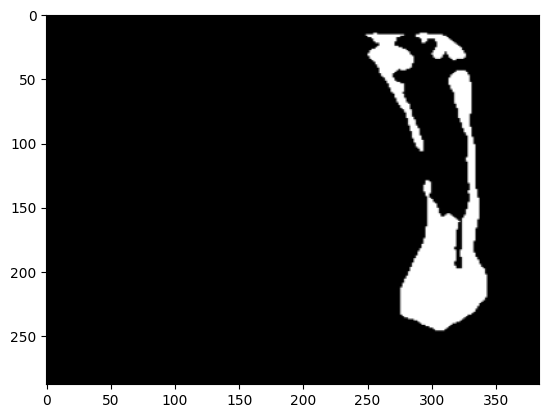

In [10]:
mask = mask[-1]

# Convert torch tensor to numpy array
mask = mask.detach().cpu().numpy()

# Convert output to a 2-d array
mask = np.squeeze(np.squeeze(mask, axis=0), axis=0)

# Convert output to binary based on threshold
mask[mask > -2.5] = 255
mask[mask <= -2.5] = 0

# Resize the ouptut image to input image size
mask = cv2.resize(mask, (im_width, im_height))

# Plot the generated mask
plt.imshow(mask, cmap="gray")

## Read and plot the ground truth mask

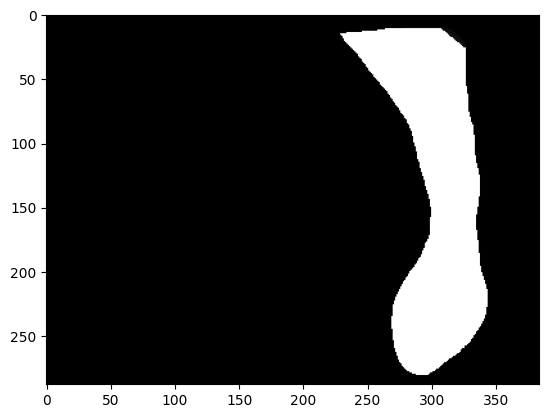

In [12]:
actual_mask = "input/PNG/Ground Truth/115.png"
am = plt.imread(actual_mask)
plt.imshow(am, cmap="gray")